In [1]:
#Importing all the important libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

# Data Reading/Data Understanding

Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Importing Skin Cancer Data
# Defining the path for train and test images
data_dir_train = pathlib.Path("C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [4]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [5]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

# Dataset Creation

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [6]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [9]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset Visualisation

Creating a code to visualize one instance of all the nine classes present in the dataset

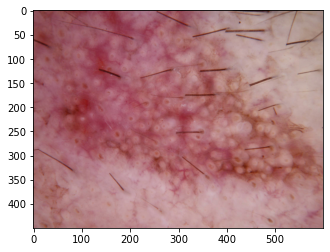

In [10]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

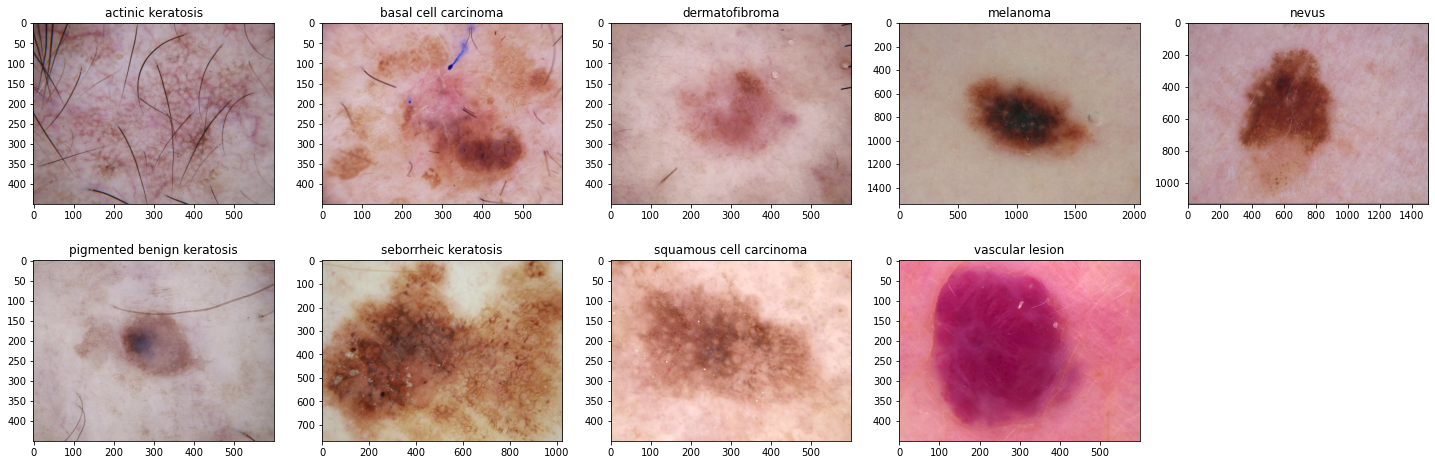

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [12]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Model Building & Training : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [14]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 199s 3s/step - loss: 2.4039 - accuracy: 0.3080 - val_loss: 1.5829 - val_accuracy: 0.4609
Epoch 2/20
56/56 [==============================] - 149s 3s/step - loss: 1.4959 - accuracy: 0.4715 - val_loss: 1.4245 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 150s 3s/step - loss: 1.3335 - accuracy: 0.5229 - val_loss: 1.3718 - val_accuracy: 0.5459
Epoch 4/20
56/56 [==============================] - 150s 3s/step - loss: 1.2066 - accuracy: 0.5742 - val_loss: 1.3923 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 150s 3s/step - loss: 1.0853 - accuracy: 0.6177 - val_loss: 1.4035 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 150s 3s/step - loss: 0.9450 - accuracy: 0.6708 - val_loss: 1.5573 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 151s 3s/step - loss: 0.9002 - accuracy: 0.6864 - val_loss: 1.4847 - val_accuracy: 0.5078
Epoch 8/20
56

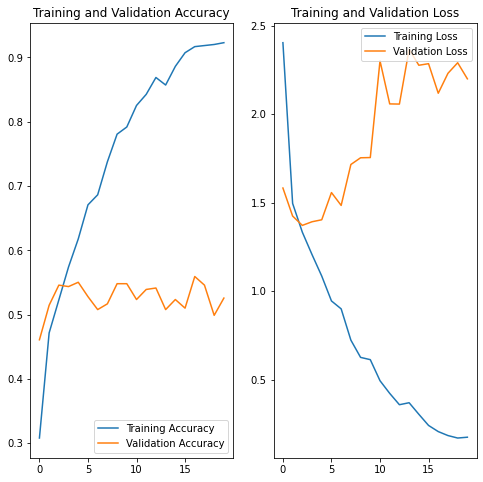

In [17]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy stall at 50% accuracy in training process.</li>
            <li>As the training loss dereases with epochs the validation loss increases.</li>
            <li>The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around <b>50%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>noticeable</b> which is a sign of overfitting.</li>
        </ol>
    </span>    
</div>

# Choosing an appropiate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps exposing the model to more aspects of the data and generalize better.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

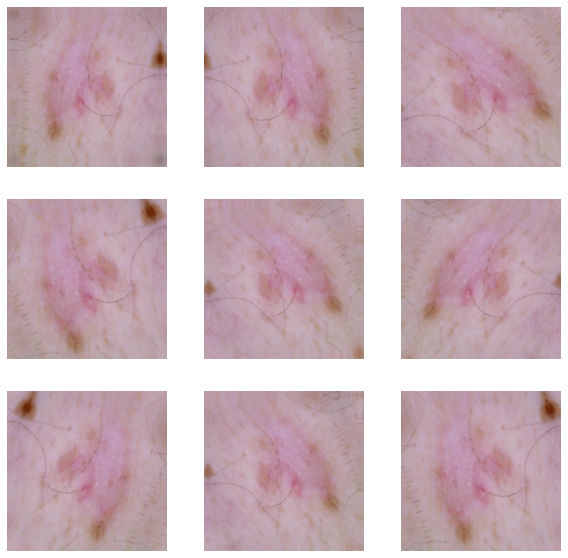

In [19]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [20]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [21]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [22]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 156s 3s/step - loss: 3.1714 - accuracy: 0.2266 - val_loss: 1.9739 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 154s 3s/step - loss: 1.9029 - accuracy: 0.2835 - val_loss: 1.8200 - val_accuracy: 0.3356
Epoch 3/20
56/56 [==============================] - 155s 3s/step - loss: 1.7722 - accuracy: 0.3387 - val_loss: 1.6574 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 155s 3s/step - loss: 1.6704 - accuracy: 0.3968 - val_loss: 1.7226 - val_accuracy: 0.3826
Epoch 5/20
56/56 [==============================] - 155s 3s/step - loss: 1.5815 - accuracy: 0.4336 - val_loss: 1.7548 - val_accuracy: 0.3691
Epoch 6/20
56/56 [==============================] - 158s 3s/step - loss: 1.5058 - accuracy: 0.4626 - val_loss: 1.5513 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 156s 3s/step - loss: 1.4080 - accuracy: 0.4911 - val_loss: 1.3726 - val_accuracy: 0.5324
Epoch 8/20
56

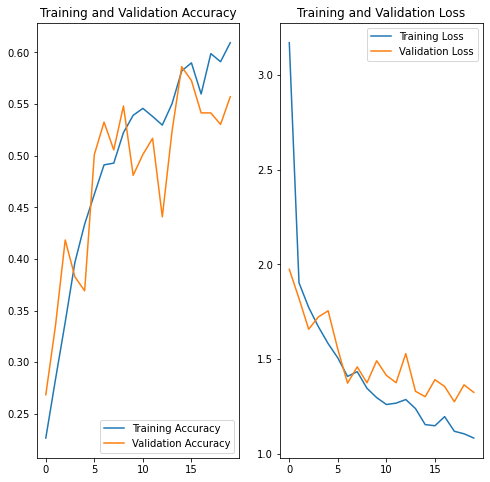

In [23]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
            <li>As the training loss decreases with epochs the validation loss decreases and stalls.</li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is still <b>slightly noticeable</b> which is a sign of overfitting.</li>
        </ol>
    </span>    
</div>

# Model Building & training on the augmented data with dropout : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [24]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [25]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [26]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 173s 3s/step - loss: 2.8335 - accuracy: 0.2227 - val_loss: 1.8719 - val_accuracy: 0.2528
Epoch 2/20
56/56 [==============================] - 169s 3s/step - loss: 1.6621 - accuracy: 0.4146 - val_loss: 1.5006 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 181s 3s/step - loss: 1.4858 - accuracy: 0.4693 - val_loss: 1.4563 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 166s 3s/step - loss: 1.4091 - accuracy: 0.5056 - val_loss: 1.4841 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 171s 3s/step - loss: 1.3215 - accuracy: 0.5312 - val_loss: 1.3654 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 176s 3s/step - loss: 1.3337 - accuracy: 0.5262 - val_loss: 1.3803 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 174s 3s/step - loss: 1.2376 - accuracy: 0.5530 - val_loss: 1.3079 - val_accuracy: 0.5414
Epoch 8/20
56

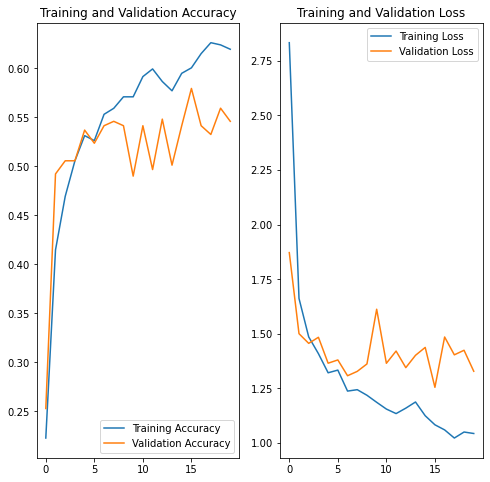

In [27]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
            <li><b>As the training loss decreases with epochs the validation loss decreases</b></li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
        </ol>
    </span>    
</div>

### **We can clearly see that the overfitting of the model has reduced significantly when compared the earlier models**

# Class distribution: 

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>Which class has the least number of samples?<br>
            <b>seborrheic keratosis with 77 samples</b></li>
            <li>Which classes dominate the data in terms proportionate number of samples?<br>
            <b>pigmented benign keratosis with 462 samples</b></li>
        </ol>
    </span>    
</div>

# Handling class imbalances: 

Rectifing class imbalances present in the training dataset with Augmentor library.

In [29]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


In [30]:
path_to_training_dataset="C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27F3A5FF520>: 100%|█| 500/500 [00:09<00:00, 50.22 Samples/


Initialised with 376 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27F3ECBDA30>: 100%|█| 500/500 [00:08<00:00, 58.15 Samples/


Initialised with 95 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27F3A5CCCA0>: 100%|█| 500/500 [00:09<00:00, 53.81 Samples/


Initialised with 438 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27F3E9DE670>: 100%|█| 500/500 [00:44<00:00, 11.16 Samples


Initialised with 357 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/nevus/.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x27F024BA3D0>: 100%|█| 500/500 [00:48<00:00, 10.26 Samples/


Initialised with 462 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27F14153250>: 100%|█| 500/500 [00:08<00:00, 56.45 Samples/


Initialised with 77 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27F3EBD1610>: 100%|█| 500/500 [00:22<00:00, 22.43 Samples


Initialised with 181 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27F3E9E9100>: 100%|█| 500/500 [00:09<00:00, 55.26 Samples/


Initialised with 139 image(s) found.
Output directory set to C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27F3EA1F580>: 100%|█| 500/500 [00:08<00:00, 56.40 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
data_dir_train = pathlib.Path("C:/Users/HP/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/OutputDirectory/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob
import os
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [33]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [34]:
df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [35]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


# Model Building & training on the rectified class imbalance data : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [38]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [39]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [40]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 [==============================] - 343s 3s/step - loss: 2.5030 - accuracy: 0.2425 - val_loss: 1.7909 - val_accuracy: 0.2767
Epoch 2/30
113/113 [==============================] - 332s 3s/step - loss: 1.7165 - accuracy: 0.3461 - val_loss: 1.8639 - val_accuracy: 0.2600
Epoch 3/30
113/113 [==============================] - 333s 3s/step - loss: 1.6136 - accuracy: 0.3703 - val_loss: 1.5859 - val_accuracy: 0.3789
Epoch 4/30
113/113 [==============================] - 334s 3s/step - loss: 1.4467 - accuracy: 0.4356 - val_loss: 1.3978 - val_accuracy: 0.4822
Epoch 5/30
113/113 [==============================] - 339s 3s/step - loss: 1.4042 - accuracy: 0.4550 - val_loss: 1.4173 - val_accuracy: 0.4556
Epoch 6/30
113/113 [==============================] - 335s 3s/step - loss: 1.3414 - accuracy: 0.4728 - val_loss: 1.3631 - val_accuracy: 0.4978
Epoch 7/30
113/113 [==============================] - 335s 3s/step - loss: 1.3285 - accuracy: 0.4844 - val_loss: 1.4412 - val_accuracy: 0.4533

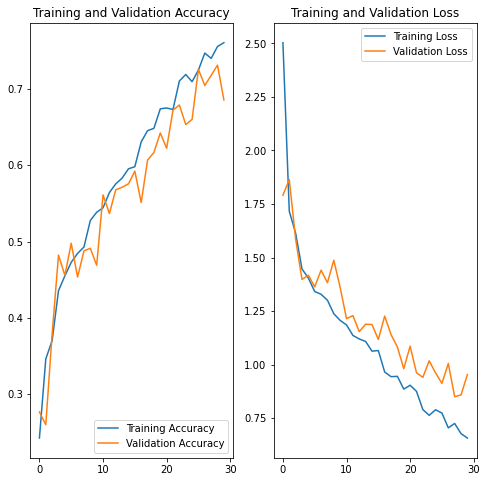

In [41]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.</li>
            <li>As the training loss decreases with epochs the validation loss also decreases.</li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around <b>75%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
        </ol>
    </span>    
</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <p>Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.</p>  
    </span>    
</div>